<h1 align = "center"> MSU-NIST </h1>

## CS:3210 Machine Learning Final Project
### Professor: Feng Jiang 


#### Team Members:
* **Ling Thang**
* **Joaquin Trujillo**

#### Project Description:
For our Final project we have decided to work on the classic digit recognition problem. Taking a spin on the classic MNSIT dataset we have decided to collect our own dataset from study around the Auraria campus housing the three schools MSU Denver, CU Denver, and CCD. We decided to take this approach because we believe that as machine learning students it is not only important to understand not just the application of machine learning but also the data collection, cleaning, and preprocessing that goes into it. We believe that this will give us a better understanding of the process and the challenges that come with it as well as the importance of data quality.

In [102]:
# Standard library imports
import os
from PIL import Image

# Third-party library imports
import numpy as np
import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from keras.utils import to_categorical

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

# Naigate to the folder and create classes for Digit Recognition

In [94]:
data_dir = 'Data'
# classes but only the directories
files = os.listdir(data_dir)
classes = [f for f in files if os.path.isdir(os.path.join(data_dir, f))]

print(sorted(classes))

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


# Preprocessing the data 

## create two arrays X and y

## Loop through the 

In [98]:
# Create empty np arrarys to store the images and labels
X = []
y = []

# Loop through the classes
for i, c in enumerate(classes):
    files = os.listdir(os.path.join(data_dir, c))
    files = [f for f in files if f.endswith('.png')]
    
    # print the number of files in each class
    print(f'{c}: {len(files)}')

    # Loop through the images
    for f in files:
        img = Image.open(os.path.join(data_dir, c, f))
        img = img.resize((28, 28))
        img = np.array(img)
        img = img / 255
        img = img.astype(np.float32)
        X.append(img)
        y.append(i)

# Convert lists to arrays
X = np.array(X)
y = np.array(y)

print(X.shape)

0: 100
8: 100
1: 100
5: 100
9: 100
2: 100
7: 100
4: 100
3: 100
6: 100


In [101]:
# print the shape of the arrays
print(X.shape)
print(y.shape)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert the labels to one-hot encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Save the data
np.save('X_train.npy', X_train)
np.save('X_test.npy', X_test)
np.save('y_train.npy', y_train)
np.save('y_test.npy', y_test)
np.save('classes.npy', classes)

#print('Data saved')
print('X_train shape:', X_train.shape)
print (y_train.shape)


(1000, 28, 28, 4)
(1000,)
X_train shape: (800, 28, 28, 4)
(800, 10)


In [88]:
# Load the data
X_train = np.load('X_train.npy')
X_test = np.load('X_test.npy')
y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')
classes = np.load('classes.npy')

print('Data loaded')
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(sorted(classes))



Data loaded
(800, 28, 28, 4)
(200, 28, 28, 4)
(800, 10)
(200, 10)
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


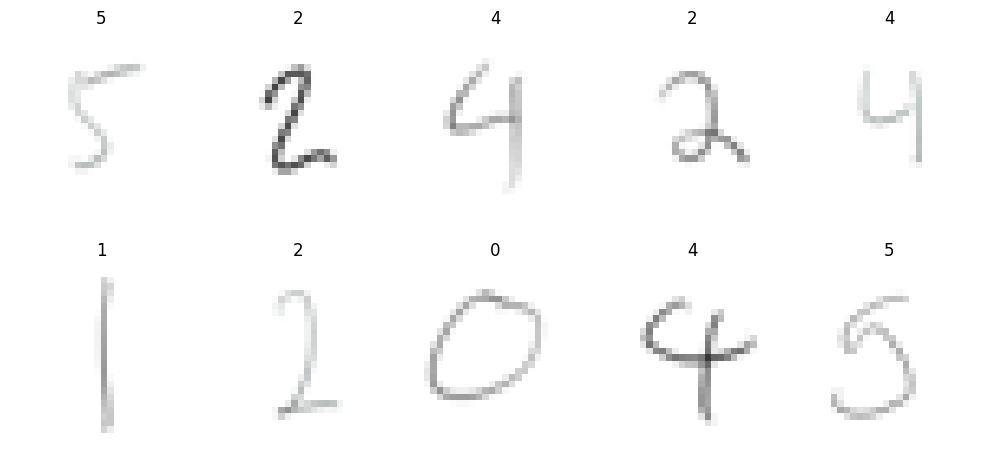

In [89]:
# print a random sample images
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 5, figsize=(10, 5))
axes = axes.ravel()

for i in range(10):
    idx = np.random.randint(0, X_train.shape[0])
    axes[i].imshow(X_train[idx])
    axes[i].set_title(classes[np.argmax(y_train[idx])])
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [90]:
# data augmentation
datagen = ImageDataGenerator(
      rotation_range=10,  
        zoom_range = 0.10,  
        width_shift_range=0.1, 
        height_shift_range=0.1)

augmented_X = []
augmented_y = []

# Generate augmented data for each sample in the dataset
for i in range(len(X_train)):
    X_train_example = X_train[i].reshape((1, 28, 28, 4))
    y_train_example = y_train[i].reshape((1, 10))
    num_augmented_samples = 5  # You can adjust the number of augmented samples per original sample
    for _ in range(num_augmented_samples):
        X_train_augmented, y_train_augmented = datagen.flow(X_train_example, y_train_example).__next__()
        # Reshape augmented data to remove extra dizmension
        X_train_augmented = X_train_augmented.squeeze(axis=0)
        y_train_augmented = y_train_augmented.squeeze(axis=0)
        augmented_X.append(X_train_augmented)
        augmented_y.append(y_train_augmented)

# Convert lists to numpy arrays
augmented_X = np.array(augmented_X)
augmented_y = np.array(augmented_y)

# Print the shape of the augmented dataset
print("Shape of augmented dataset:", augmented_X.shape)
print("Shape of augmented labels:", augmented_y.shape)

Shape of augmented dataset: (4000, 28, 28, 4)
Shape of augmented labels: (4000, 10)


In [91]:
def intialize_model_train(epoch, batch_size):
	model = Sequential()
	model.add(Conv2D(6, kernel_size=(5, 5), padding="valid", activation='relu', input_shape=(28, 28, 4)))
	model.add(MaxPooling2D(pool_size=(2, 2)))
	model.add(Conv2D(16, kernel_size=(5, 5), padding="valid", activation='relu'))
	model.add(MaxPooling2D(pool_size=(2, 2)))
	model.add(Flatten())
	model.add(Dense(120, activation='relu'))
	#model.add(Dropout(0.5))
	model.add(Dense(84, activation='relu'))
	model.add(Dropout(0.5))
	model.add(Dense(10, activation='softmax'))

	print("******* training network *******")
# Compile the model with Adam optimizer
	adam_optimizer = Adam(learning_rate=0.001)  # You can adjust the learning rate as needed
	model.compile(loss="categorical_crossentropy", optimizer=adam_optimizer, metrics=["accuracy"])
	# go through the data 5 times with 128 batch sizes
	H = model.fit(augmented_X,augmented_y, validation_data=(X_test, y_test),
		epochs=epoch, batch_size=batch_size)

	# evaluate the network
	print("******* evaluating network *******")
	predictions = model.predict(X_test, batch_size=batch_size)
	print(classification_report(y_test.argmax(axis=1),
		predictions.argmax(axis=1)))

In [92]:
intialize_model_train(8,50)

******* training network *******
Epoch 1/8


/home/powoly/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.1066 - loss: 2.3079 - val_accuracy: 0.0650 - val_loss: 2.3051
Epoch 2/8
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1454 - loss: 2.2764 - val_accuracy: 0.4600 - val_loss: 1.8817
Epoch 3/8
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3543 - loss: 1.8801 - val_accuracy: 0.7450 - val_loss: 1.1929
Epoch 4/8
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4769 - loss: 1.5470 - val_accuracy: 0.7700 - val_loss: 0.9740
Epoch 5/8
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5575 - loss: 1.3085 - val_accuracy: 0.7800 - val_loss: 0.7939
Epoch 6/8
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6161 - loss: 1.1590 - val_accuracy: 0.8150 - val_loss: 0.6937
Epoch 7/8
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6292 - loss: 1.0751 - val_accuracy: 0.8450 - val_loss: 0.6346
Epoch 8/8
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6914 - loss: 0.9158 - val_accuracy: 0.8650 - val_loss: 0.5651
******* ev